In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from function import *
import numpy as np
from sklearn.preprocessing import StandardScaler
from plotly.offline import plot
from plotly.graph_objs import *
import seaborn as sns

In [136]:
# load data
file_path = 'forestfires_with_fwi_bui.csv'
df = pd.read_csv(file_path)

# Assign the risk levels based on ISI 
isi_bins = [0, 2, 6, 12, 17, 23, 30, float('inf')]
fwi_bins = [0, 8.5, 17.2, 24.6, 38.3, 50, 64, float('inf')]
ist_risk = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Maximum', 'Extreme']
fwi_risk = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Maximum', 'Extreme']

# Create a new column for ISI risk level
df['ISI_Risk'] = pd.cut(df['ISI'], bins=isi_bins, labels=ist_risk, right=False)
df['FWI_Risk'] = pd.cut(df['FWI'], bins=fwi_bins, labels=fwi_risk, right=False)

print(df.head())

   X  Y  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area   BUI   FWI  \
0  7  5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0  30.9  10.3   
1  7  4  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0  62.5  18.7   
2  7  4  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0  75.4  20.7   
3  8  6  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0  33.3  16.7   
4  8  6  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0  51.2  21.9   

   ISI_Risk  FWI_Risk  
0       Low       Low  
1  Moderate  Moderate  
2  Moderate  Moderate  
3  Moderate       Low  
4  Moderate  Moderate  


##### a) Visualize the data over these features in 2D/3D PC plane

In [137]:
feature_df = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'BUI', 'FWI', 'area']]
# sns.pairplot(feature_df)

print(feature_df.head())

   FFMC   DMC     DC  ISI  temp  RH  wind  rain   BUI   FWI  area
0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0  30.9  10.3   0.0
1  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0  62.5  18.7   0.0
2  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0  75.4  20.7   0.0
3  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2  33.3  16.7   0.0
4  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0  51.2  21.9   0.0


##### (b) Choose between conventional PCA or SVD for the visualization. Make a comment whether one of the normalizations is better and why.
I think z score normalization shows more intense pattern in pca plot, because z score normalization makes all features contribute equally to variance.
and the main idea of pca is select the highest variance in higher component.

In [138]:
# Normalize the data 
def normalize_data(feature_df, method):
    """
    Normalize data with Range or Z-score, centralize data and reture x, y .
    Args: data, method
    Output: x: feature, y: target
    """
    # Normalize feature data
    x = feature_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'BUI', 'FWI']]
    y = feature_df[['area']]

    for col in x.columns:
        x.loc[:, col] = method(x[col])

    # center the data
    x = x - x.mean(axis=0)
    return x, y

x_range, y_range = normalize_data(feature_df, normalization_range)
x_zscore, y_zscore = normalize_data(feature_df, normalization_zscore)

# Calculate eigenvalues and eigenvectors for the range normalized data
e_Range, v_Range = caulate_eingenvalues_eingenvectors(x_range)
print('Eigenvectors \n%s' %e_Range)
print('\nEigenvalues \n%s' %v_Range)


# Calculate eigenvalues and eigenvectors for the Z-score normalized data
e_z, v_z = caulate_eingenvalues_eingenvectors(x_zscore)
print('Eigenvectors \n%s' %e_z)
print('\nEigenvalues \n%s' %v_z)



Eigenvectors 
[1.90003174e-01 5.11513488e-02 2.42696428e-02 1.60361988e-02
 9.56443423e-03 2.65098530e-03 4.42676877e-04 1.24827471e-04]

Eigenvalues 
[[-0.07679957  0.09671294  0.1081912  -0.1612524   0.19854565 -0.95031776
   0.06715766 -0.00252875]
 [-0.45312596 -0.19172467  0.4688261   0.3773807   0.11038855  0.04850503
   0.28932311  0.54539726]
 [-0.60725707 -0.07964926 -0.76020386 -0.1109176   0.03163229 -0.01054384
   0.14034267  0.11778958]
 [-0.07537629  0.08404527  0.2087261  -0.46769892  0.15600611  0.20361258
   0.74104075 -0.33167538]
 [-0.27674117  0.51888439  0.14575756 -0.0340601  -0.79139909 -0.06536695
   0.03435723 -0.00147655]
 [ 0.0375552  -0.79742811  0.08139198 -0.30531534 -0.49675742 -0.12577401
   0.01577736 -0.00446596]
 [-0.5110145  -0.15721568  0.22910323  0.24487359  0.09520952  0.01134205
  -0.28697303 -0.71424718]
 [-0.27423361  0.10310812  0.25818994 -0.66797893  0.20226263  0.18097952
  -0.50907922  0.26168938]]
Eigenvectors 
[4.32551328e+00 1.50039901

In [139]:
def pca_transform(x_norm, y, v):
    """
    PCA transformation
    Args: x_norm, y, v
    Output: pc: PCA component space, data_pca: PCA scores
    """
    # generate PCA component space (PCA scores)
    pc = np.dot(x_norm, v)
    # set data to a Pandas Dataframa to ease plotting
    names = ["PC_"+str(x+1) for x in range(pc.shape[1])]
    names.append('Area')
    data_pca = pd.DataFrame(data= np.c_[pc, y], 
                        columns=names)
    data_pca['Area'] = data_pca['Area'].astype(int)
    return pc, data_pca

# PCA transformation
pc_Range, data_pca_Range = pca_transform(x_range, y_range, v_Range)
pc_z, data_pca_z = pca_transform(x_zscore, y_zscore, v_z)

# print(data_pca_Range.head())


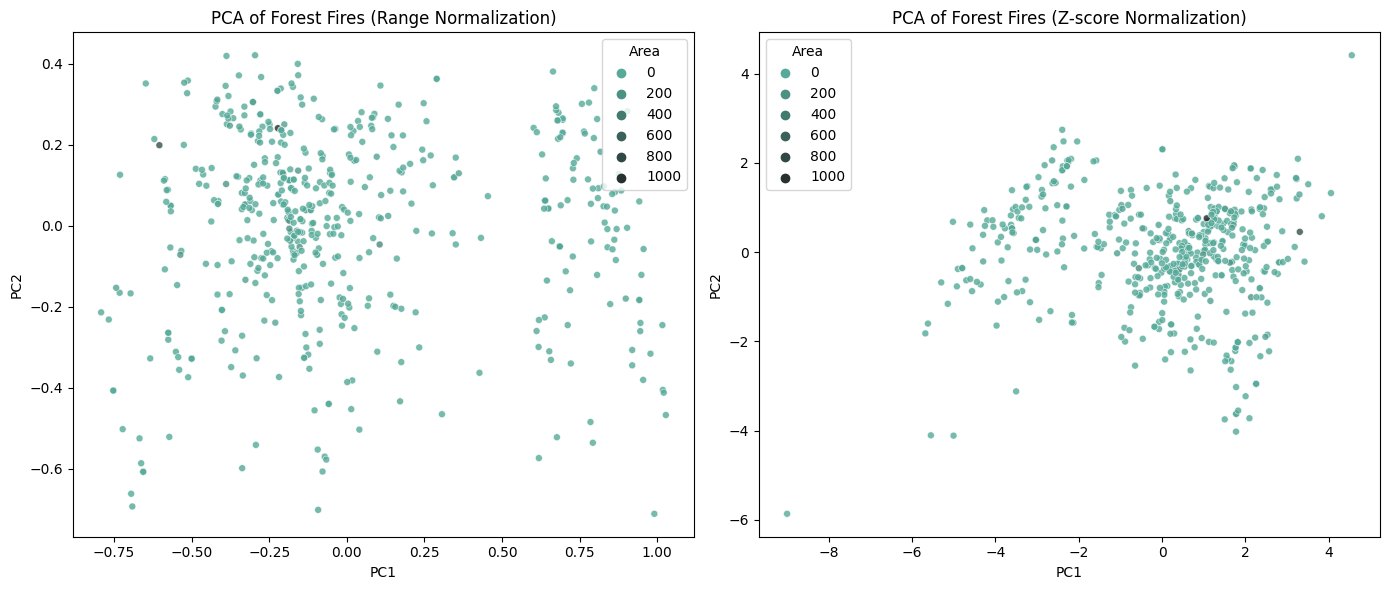

In [140]:
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='Area',
                palette='dark:#5A9_r', 
                alpha=0.8, 
                s=25, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
# set custom color palette
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='Area', 
                palette='dark:#5A9_r',
                alpha=0.8, 
                s=25, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

# print(data_pca_Range['Area'].values)
# print(data_pca_z['Area'].values)


##### c) At these visualizations, use a distinct shape/colour for data points representing a pre‐specified group of objects. Comment on the choice of your groups.

FWI_Risk is better than ISI risk

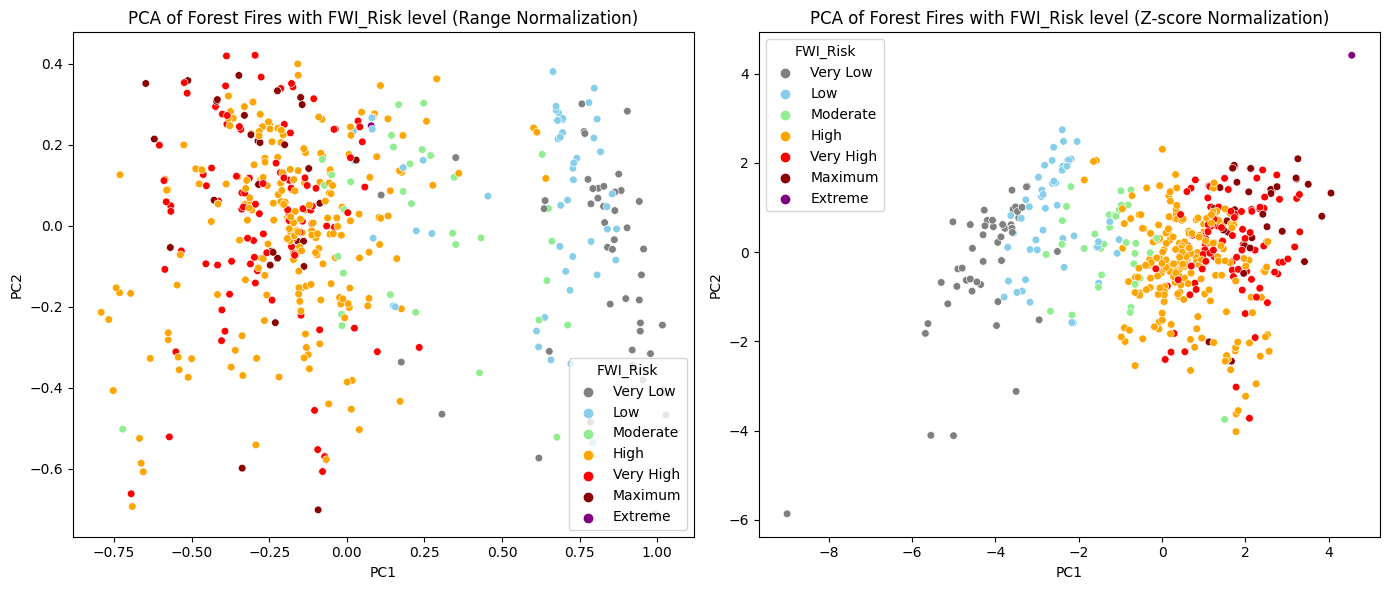

In [141]:
data_pca_Range['FWI_Risk'] = df['FWI_Risk'].values
data_pca_z['FWI_Risk'] = df['FWI_Risk'].values

custom_palette = {
    'Very Low': 'gray', 
    'Low': 'skyblue', 
    'Moderate': 'lightgreen', 
    'High': 'orange', 
    'Very High': 'red', 
    'Maximum': 'darkred', 
    'Extreme': 'purple'
}
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='FWI_Risk',
                palette=custom_palette, 
                alpha=1, 
                s=30, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires with FWI_Risk level (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='FWI_Risk', 
                palette=custom_palette,
                alpha=1, 
                s=30, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires with FWI_Risk level (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()


##### d) Calculate and make a graphical presentation of the “quality” of the PC projection of your data. Discuss your results.

In [142]:
# Range Normalization
totVar = sum(e_Range)       #Total variability of the Data
var_exp = [(i / totVar)*100 for i in sorted(e_Range, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,12)],
        y=var_exp,
        name='Exp Var',
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,12)], 
        y=cum_var_exp,
        name='Cum. Exp Var')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained Variance in percentage (Range Normalization)')

fig = Figure(data=data, layout=layout)
plot(fig)

/Users/user/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/user/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




'temp-plot.html'

In [ ]:
# Z-score Normalization
totVar = sum(e_z)       #Total variability of the Data
var_exp = [(i / totVar)*100 for i in sorted(e_z, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,12)],
        y=var_exp,
        name='Exp Var',
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,12)], 
        y=cum_var_exp,
        name='Cum. Exp Var')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained Variance in percentage (Z-score Normalization)')

fig = Figure(data=data, layout=layout)
plot(fig)

'temp-plot.html'

#### SVD

In [146]:
print(df[['BUI', 'FWI']])
print(1/2**0.5)

       BUI   FWI
0     30.9  10.3
1     62.5  18.7
2     75.4  20.7
3     33.3  16.7
4     51.2  21.9
..     ...   ...
512   93.5   8.7
513   93.5   8.7
514   93.5   8.7
515  183.2  41.5
516    5.6   0.5

[517 rows x 2 columns]
0.7071067811865475


In [ ]:
small = df[['BUI', 'FWI', 'area']]
big = feature_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'BUI', 'FWI']]



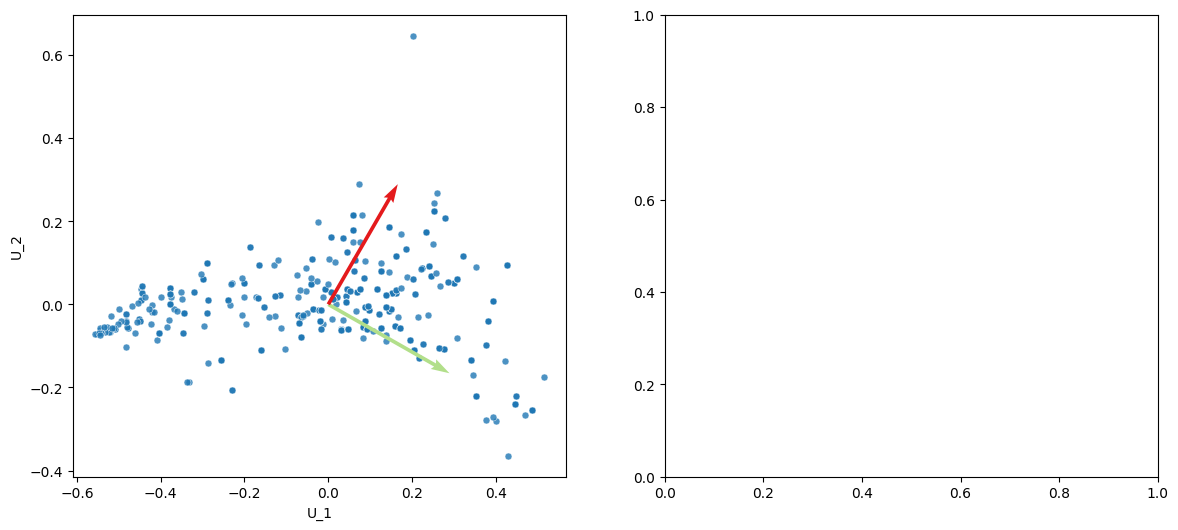

In [ ]:
x = small[['BUI', 'FWI']]

# center the data
x = x - x.mean(axis=0)
x = normalization_range(x)
y = small['area']

u, s, vh = np.linalg.svd(big, full_matrices=True)

## Calculate the coordinates of the data points in the projection axes of the space spanned 
## by the leading eigenvectors contained in $U$ 
u1 = u[:,0] * s[0] 
u2 = u[:,1] * s[1] 
# set data to a Pandas Dataframa to ease plotting
names = ["U_"+str(i+1) for x in range(2)]
names.append('target')
ds_us = pd.DataFrame(data= np.c_[u1, u2, y], 
                     columns=names)
ds_us['target'] = ds_us['target'].astype(int)

# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=ds_us, 
                x='U_1', 
                y='U_2', 
                alpha=0.8, 
                s=25, 
                ax=axes[0])

# plot the vh vector
vh = vh*0.2
axes[0].quiver(0, 0, vh[0, 0], vh[1, 0], scale_units='xy', angles='xy', scale=0.6, color='#b2df8a', label='Loading 1')
axes[0].quiver(0, 0, vh[0, 1], vh[1, 1], scale_units='xy', angles='xy', scale=0.6, color='#e41a1c', label='Loading 2')